![ScreenShot](images/loading_screen.png)

# Project 3 - Behavioral Cloning
### _How to Train a Deep Neural Network to Drive a Simulated Car_ 
#### Please refer to this repository's README.md for a detailed explanation of the project: https://github.com/nhiddink/CarND_P3_Behavioral_Cloning/blob/master/README.md

In [1]:
import os
import json

# http://pandas.pydata.org/
import pandas as pd

# http://www.numpy.org/
import numpy as np

# http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html
import cv2

# http://matplotlib.org/
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# http://scikit-learn.org/stable/
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# https://keras.io/
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, Flatten, Lambda
from keras.optimizers import Adam
from keras.models import model_from_json

Using TensorFlow backend.


## Data Summary & Pre-Processing

In [2]:
# Declare variables
folder = './data/'
csv_path = 'driving_log.csv'

# Load data from driving_log.csv using Pandas
training_data = pd.read_csv(folder + csv_path, delimiter=None, header='infer', names=None)
print('Sample Entry from driving_log.csv: \n{}'.format(training_data.head(1)))

Sample Entry from driving_log.csv: 
                                   center  \
0  IMG/center_2016_12_01_13_30_48_287.jpg   

                                    left  \
0   IMG/left_2016_12_01_13_30_48_287.jpg   

                                    right  steering  throttle  brake     speed  
0   IMG/right_2016_12_01_13_30_48_287.jpg       0.0       0.0    0.0  22.14829  


In [3]:
X_train = training_data[['left','center','right']]
Y_train = training_data['steering']

# Split training, validation, and test sets
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Remove pandas index and convert to matrix
X_left  = X_train['left'].as_matrix()
X_right = X_train['right'].as_matrix()
X_train = X_train['center'].as_matrix()
X_valid = X_valid['center'].as_matrix()

# Remove pandas index and convert to float32 matrix
Y_train = Y_train.as_matrix()
Y_train = Y_train.astype(np.float32)
Y_valid = Y_valid.as_matrix()
Y_valid = Y_valid.astype(np.float32)

print('Data sets split and converted.')

Data sets split and converted.


In [4]:
# Shuffle data
X_left, X_right, X_train, Y_train = shuffle(X_left, X_right, X_train, Y_train, random_state=0)
print('Data sets shuffled.')

Data sets shuffled.


## Data Augmentation - Helper Functions

In [5]:
def read_next_image(ex, value, X_train, X_left, X_right, Y_train):
    offset = 1.2
    dist = 20.0
    steering = Y_train[ex]
    
    if value == 0:
        image = plt.imread(folder + X_left[ex].replace(' ',''))
        dsteering = offset / dist * 360 / (2 * np.pi) / 25.0
        steering += dsteering
    elif value == 1:
        image = plt.imread(folder + X_train[ex].replace(' ',''))
    elif value == 2:
        image = plt.imread(folder + X_right[ex].replace(' ',''))
        dsteering = -offset / dist * 360 / ( 2 * np.pi) / 25.0
        steering += dsteering
    else:
        print ('Invalid value :', value )
    
    return image, steering

def random_crop(image, steering=0.0, tx_lower=-20, tx_upper=20, ty_lower=-2, ty_upper=2, rand=True):
    shape = image.shape
    col_start, col_end = abs(tx_lower), shape[1]-tx_upper
    horizon = 60;
    bonnet = 136
    if rand:
        tx= np.random.randint(tx_lower,tx_upper+1)
        ty= np.random.randint(ty_lower,ty_upper+1)
    else:
        tx, ty = 0, 0
    
    random_crop = image[horizon + ty : bonnet + ty, col_start + tx : col_end + tx, :]
    image = cv2.resize(random_crop, (64,64), cv2.INTER_AREA)
     
    if tx_lower != tx_upper:
        dsteering = -tx/(tx_upper-tx_lower)/3.0
    else:
        dsteering = 0
    steering += dsteering
    
    return image, steering

def random_shear(image,steering,shear_range):
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    p1 = np.float32([[0, rows],[cols, rows],[cols / 2, rows / 2]])
    p2 = np.float32([[0, rows],[cols, rows],random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0    
    M = cv2.getAffineTransform(p1, p2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering += dsteering
    return image, steering

def random_flip(image, steering):
    coin = np.random.randint(0, 2)
    if coin==0:
        image, steering = cv2.flip(image, 1), -steering
    return image, steering

def random_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = 0.8 + 0.4*(2*np.random.uniform()-1.0)    
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def generate_training_example(X_train, X_left, X_right, Y_train):
    ex = np.random.randint(0, len(Y_train))
    value = np.random.randint(0, 3)
    image, steering = read_next_image(ex, value, X_train, X_left, X_right, Y_train)
    image, steering = random_shear(image, steering, shear_range=100)   
    image, steering = random_crop(image, steering, tx_lower=-20, tx_upper=20, ty_lower=-10, ty_upper=10)
    image, steering = random_flip(image, steering)
    image = random_brightness(image)
    return image,steering

def get_validation_set(X_valid, Y_valid):
    X = np.zeros((len(X_valid), 64, 64, 3))
    Y = np.zeros(len(X_valid))
    for i in range(len(X_valid)):
        x, y = read_next_image(i, 1, X_valid, X_valid, X_valid, Y_valid)
        X[i], Y[i] = random_crop(x, y, tx_lower=0, tx_upper=0, ty_lower=0, ty_upper=0)
    return X, Y
    
def generate_train_batch(X_train, X_left, X_right, Y_train, batch_size):
    batch_images = np.zeros((batch_size, 64, 64, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            x, y = generate_training_example(X_train, X_left, X_right, Y_train)
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering

## Data Augmentation - Visualization

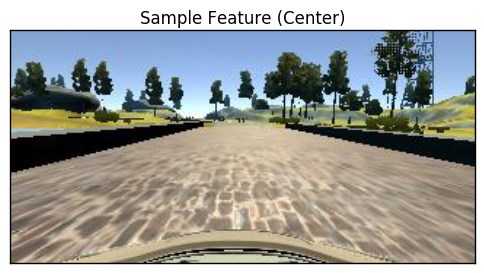

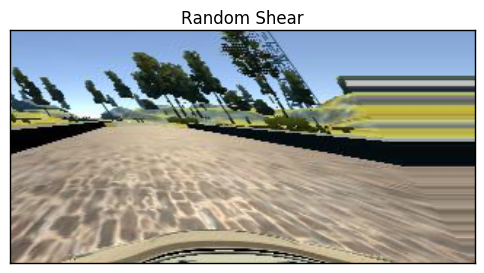

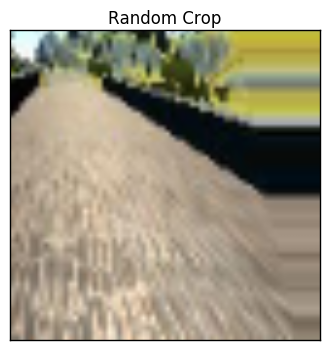

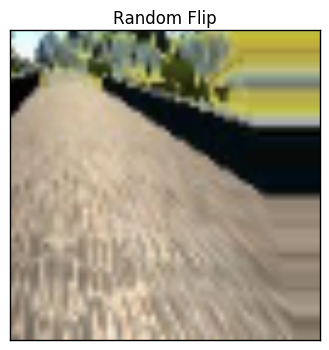

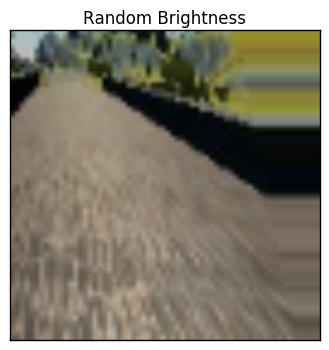

In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

#Sample
img = plt.imread('data/IMG/center_2016_12_01_13_30_48_287.jpg')
steering = 0.001
plt.imshow(img);
plt.title('Sample Feature (Center)')
plt.imsave('images/sample_feature.jpg', img)
plt.xticks(()); plt.yticks(());

#Shear
img_shear, steering_shear = random_shear(img, steering, 100)
plt.figure()
plt.imshow(img_shear)
plt.title('Random Shear')
plt.imsave('images/random_shear.jpg', img_shear)
plt.xticks(()); plt.yticks(());

#Crop
img_crop, steering_crop = random_crop(img_shear, steering_shear, tx_lower=-20, tx_upper=20, ty_lower=-10, ty_upper=10, rand=True)
plt.figure()
plt.imshow(img_crop)
plt.title('Random Crop')
plt.imsave('images/random_crop.jpg', img_crop)
plt.xticks(()); plt.yticks(());

#Flip
img_flip, steering_flip = random_flip(img_crop, steering_crop)
plt.figure()
plt.imshow(img_flip)
plt.title('Random Flip')
plt.imsave('images/random_flip.jpg',img_flip)
plt.xticks(()); plt.yticks(());

#Brightness
img_bright = random_brightness(img_flip)
plt.figure()
plt.imshow(img_bright)
plt.title('Random Brightness')
plt.imsave('images/random_brightness.jpg', img_bright)
plt.xticks(()); plt.yticks(());

## Training Sequence

In [7]:
batch_size = 200
train_generator = generate_train_batch(X_train, X_left, X_right, Y_train, batch_size)
X_valid, Y_valid = get_validation_set(X_valid, Y_valid)

print('X_train data type :', X_train.dtype)
print('Y_train data type :', Y_train.dtype)
print('X_valid data type :', X_valid.dtype)
print('Y_valid data type :', Y_valid.dtype)

X_train data type : object
Y_train data type : float32
X_valid data type : float64
Y_valid data type : float64


## Model Architecture

In [ ]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(64,64,3)))
model.add(Convolution2D(32, 8, 8, border_mode='same', subsample=(4,4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 8, 8, border_mode='same', subsample=(4,4)))
model.add(Activation('relu',name='relu2'))
model.add(Convolution2D(128, 4, 4, border_mode='same', subsample=(2,2)))
model.add(Activation('relu'))
model.add(Convolution2D(128, 2, 2, border_mode='same', subsample=(1,1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(1))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 16, 32)    6176        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16, 16, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 4, 4, 64)      131136      activation_1[0][0]               
___________________________________________________________________________________________

## Save model.json & model.h5

In [ ]:
model_json = 'model.json'
model_weights = 'model.h5'
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

restart = True
if os.path.isfile(model_json) and restart:
    try:
        with open(model_json) as jfile:
            model = model_from_json(json.load(jfile))
            model.load_weights(model_weights)    
        print('Loading trained model ...')
    except Exception as e:
        print('Unable to load model.', model_name, ':', e)
        raise

model.compile(optimizer=adam, loss='mse')

EPOCHS = 5
SAMPLES = 50000
history = model.fit_generator(train_generator,
                              samples_per_epoch=SAMPLES,
                              nb_epoch=EPOCHS,
                              validation_data=(X_valid, Y_valid),
                              verbose=1)

json_string = model.to_json()

print('Training complete. Saving model and weights...')

try:
    os.remove(model_json)
    os.remove(model_weights)
except OSError:
    pass   

with open(model_json, 'w') as outfile:
    json.dump(json_string, outfile)
model.save_weights(model_weights)

print('Model and weights saved to home directory.')

Loading trained model ...
Epoch 1/5
32600/50000 [==================>...........] - ETA: 39s - loss: 0.0232